# Control Theory
## 4th meeting
Systems with delay

## Delayed Differential Equations in nature
Delayed Differential Equations (DDE) can be used to describe a variety of systems that include some kind of delay. Quite interesting example comes from biological systems. A lot of biological systems express some kind of auto-stabilization capabilities, e.g. stabilization of hormone levels, blood cells count, organism temperature, etc. Production of given hormone/blood cell type, while is at least partially based on a current "measurement", may take a significant time, introducing a delay.

One of the well-known models for such fenomena is a set of **Mackey-Glass equations**, originally introduced to describe a blood cells density in a human body. While the blood cell density level is "stabilized" based on a current count, it takes at least a few days for the bone marrow to produce and release new blood cells.

$$\frac{dP(t)}{dt}=\frac{\beta_0\phi^n}{\phi^n+P(t-\tau)^n}-\gamma P(t)$$

While the equation itself is relatively simple, we can see that with a growing time delay, it produces chaotic results, as shown on animation:

In [1]:
# Initialization, imports, sympy setup, etc:
from sympy import *
from matplotlib import pyplot as plt
init_printing(use_unicode=False, wrap_line=False)
from IPython.display import display, Markdown, Math

#from jupyterthemes import jtplot
#jtplot.style()

In [2]:
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def mackey_glass(length=10000, x0=None, a=0.2, b=0.1, c=10.0, tau=23.0,
                 n=1000, sample=0.46, discard=250):
    """
    based on: https://github.com/manu-mannattil/nolitsa
    Generate time series using the Mackey-Glass equation.
    Generates time series using the discrete approximation of the
    Mackey-Glass delay differential equation described by Grassberger &
    Procaccia (1983).
    Parameters
    ----------
    length : int, optional (default = 10000)
        Length of the time series to be generated.
    x0 : array, optional (default = random)
        Initial condition for the discrete map.  Should be of length n.
    a : float, optional (default = 0.2)
        Constant a in the Mackey-Glass equation.
    b : float, optional (default = 0.1)
        Constant b in the Mackey-Glass equation.
    c : float, optional (default = 10.0)
        Constant c in the Mackey-Glass equation.
    tau : float, optional (default = 23.0)
        Time delay in the Mackey-Glass equation.
    n : int, optional (default = 1000)
        The number of discrete steps into which the interval between
        t and t + tau should be divided.  This results in a time
        step of tau/n and an n + 1 dimensional map.
    sample : float, optional (default = 0.46)
        Sampling step of the time series.  It is useful to pick
        something between tau/100 and tau/10, with tau/sample being
        a factor of n.  This will make sure that there are only whole
        number indices.
    discard : int, optional (default = 250)
        Number of n-steps to discard in order to eliminate transients.
        A total of n*discard steps will be discarded.
    Returns
    -------
    x : array
        Array containing the time series.
    """
    sample = int(n * sample / tau)
    grids = n * discard + sample * length
    x = np.empty(grids)
    x_h = np.empty(grids)

    #if x0 is None:
        #x[:n] = 0.5 + 0.05 * (-1 + 2 * np.random.random(n))
    #else:
    x[:n] = x0

    A = (2 * n - b * tau) / (2 * n + b * tau)
    B = a * tau / (2 * n + b * tau)

    for i in range(n - 1, grids - 1):
        x[i + 1] = A * x[i] + B * (x[i - n] / (1 + x[i - n] ** c) +
                                   x[i - n + 1] / (1 + x[i - n + 1] ** c))
        x_h[i+1] = x[i-n]
    return x[n * discard::sample], x_h[n * discard::sample]

delta_t = 0.01
h = 1.0
a = -1.0
time = np.arange(0.0, 30.0, delta_t)

force = []

# Generate samples for t \in [-h, 0]
X = [1.] * int(h/delta_t)
T = np.linspace(-h, 0, len(X)).tolist()

import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,12))

gs = gridspec.GridSpec(2, 1,height_ratios=[2,1])
ax1 = plt.subplot(gs[0])
ax1.set_xlim((-2,2))
ax1.set_ylim((-2,2))
ax2 = plt.subplot(gs[1])

def animate(t):
    tau = t/5.0+10.0
    x, y = mackey_glass(length=1000, discard=0, tau=tau, sample=tau/50.0, x0=0.5 + 0.05 * (-1 + 2 * np.ones(1000)))

    ax1.cla()
    
    ax1.plot(x[250:], y[250:], label=f'tau={tau}')
    ax1.set_xlim((0,1.5))
    ax1.set_ylim((0,1.5))
    ax1.legend()
    ax1.set_xlabel('x(t)')
    ax1.set_ylabel('x(t-tau)')
        
    ax2.cla()
    ax2.set_ylabel('Blood cells density')
    ax2.set_xlabel('Time')
    ax2.plot(x)
    ax2.set_ylim((0,1.5))

ani = animation.FuncAnimation(fig, animate, frames=150, interval=100)
plt.close()
HTML(ani.to_html5_video())


As shown on above example, significant delays in controlled systems may lead to unstable, chaotic behaviors, rendering systems very difficult to control.

On a side note, strange attractor this equation produces is rather nice:
![SegmentLocal](attractor4.gif "attractor")

![SegmentLocal](out.gif "attractor2")

## Solving DDE
For this excercise, we will consider a simple system with delay, described with an equation:
$$\dot{x}(t) = ax(t-h)$$

### Numerical approximation
It's fairly simple to approximate its solution using Euler's method, discussed in the previous class:

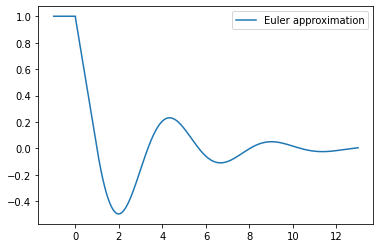

In [3]:
from numpy.linalg import inv
import numpy as np

delta_t = 0.01
h = 1.0
a = -1.0
time = np.arange(0.0, 13.0, delta_t)

# Generate samples for -h < tn < 0
X = [1.] * int(h/delta_t)
T = np.linspace(-h, 0, len(X)).tolist()

# Time-stepping solution
for i, t in enumerate(time):
    X.append(X[-1] + delta_t * a * X[i])
    T.append(t)

plt.plot(T, X, label='Euler approximation')
plt.legend()

### Analytical solution

In order to solve the system analytically, we need to know its state before $t=0$. Let's assume that for $t\leq0$, state was equal $\phi(t)=1$.

We can solve this sytem using a step method.

#### $t\in[0, h]$
First, let's solve the system in time period $t\in[0,h]$.

$$\dot{x}(t)=ax(t-h)$$
Since $0 < t < h$, following is fulfilled: $t-h < 0$. We know that in this interval $x(t-h)=1$, so:
$$\dot{x}(t)=a*1$$
Integrating the equation, we get:
$$x(t) = at+C$$
Since $x(0)=1$, we can deduce that $C=1$.
Thus:
$$x(t) = at+1\ for\ t\in[0,h]$$

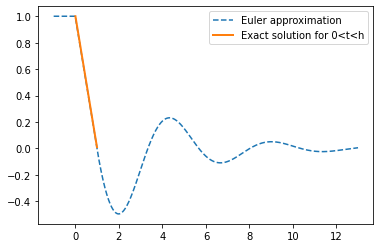

In [4]:
# Set symbols for sympy:
t = Symbol('t')
tau = Symbol('tau')
a = Symbol('a')
b = Symbol('b')
u = Symbol('u')
x0 = Symbol('x0')
t0 = Symbol('t0')
h = Symbol('h')


h_val = 1.0
a_val = -1.0

# Prepare lambdified version of the equation for plotting:
sys_0_h = a*t+1
lam_x = utilities.lambdify(t, sys_0_h.subs(a, a_val), modules=['numpy'])

# Evaluate in 0 < t < h:
time_0_h = np.arange(0.0, h_val, 0.01)
X_0_h = [lam_x(t) for t in time_0_h]

# Plot:
plt.plot(T, X, label='Euler approximation', linestyle='--')
plt.plot(time_0_h, X_0_h, linewidth=2.0, label='Exact solution for 0<t<h')
plt.legend()

#### $t\in[h, 2h]$
Knowing the solution for $t\in[0,h]$, we can compute the solution for $t\in[h,2h]$:
Since 
$$h<t<2h$$
$$0<t-h<h$$
Following is true:
$$x(t-h)=a(t-h)+1$$
We can thus derive equation:
$$\dot{x}(t)=a(a(t-h)+1)$$

In [5]:
# Calculate the integral:
sys_h_2h_no_const = Integral(a*(a*(t-h)+1), t).doit()
# sys_h_2h_no_const

After integration:
$$x(t)=\frac{a^2t^2}{2}+t(-a^2h+a) + C$$

##### Calculate constant C
We know that $x(h)=ah+1$, thus:
$$ah+1=\frac{a^2h^2}{2}+h(-a^2h+a) + C$$
$$C = ah + 1 - \frac{a^2h^2}{2}-h(-a^2h+a) $$ 

In [6]:
display(Markdown('#### Assembling equation for $x\in[h, 2h]$:'))
# substitute C in equation for x(t):
sys_h_2h = Integral(a*(a*(t-h)+1), t).doit() + a*h+1-a**2*h**2/2.0-h*(a-a**2*h)
display(Markdown('Substituting C with a calculated value in equation for x(t):'))
display(Math(f'x(t) = ' + latex(sys_h_2h)))

#### Assembling equation for $x\in[h, 2h]$:

Substituting C with a calculated value in equation for x(t):

<IPython.core.display.Math object>

In [7]:
# Substituting for a, h
lam_x = utilities.lambdify(t, sys_h_2h.subs(a, a_val).subs(h, h_val), modules=['numpy'])
display(Markdown('After substituting values for a, h:'))
display(Math('x(t)='+latex(sys_h_2h.subs(a, a_val).subs(h, h_val))))

After substituting values for a, h:

<IPython.core.display.Math object>

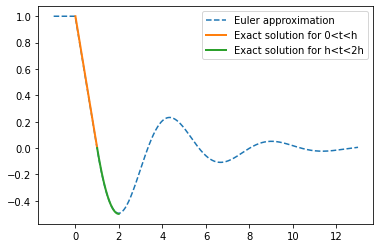

In [8]:
# Plotting
time_h_2h = np.arange(h_val, 2*h_val, 0.01)
X_h_2h = [lam_x(t) for t in time_h_2h]

plt.plot(T, X, label='Euler approximation', linestyle='--')
plt.plot(time_0_h, X_0_h, linewidth=2.0, label='Exact solution for 0<t<h')
plt.plot(time_h_2h, X_h_2h, linewidth=2.0, label='Exact solution for h<t<2h')

plt.legend()

#### $t\in[2h, 3h]$
Knowing the solution for $t\in[h,2h]$, we can compute the solution for $t\in[2h,3h]$:

Since 
$$2h<t<3h$$
$$h<t-h<2h$$
Following is true:
$$x(t-h)=\frac{a^2(t-h)^2}{2}+(t-h)(a-a^2h)$$
We can thus derive equation:
$$\dot{x}(t)=a(\frac{a^2(t-h)^2}{2}+(t-h)(a-a^2h))$$

In [9]:
display(Markdown(
    'Knowing the solution for $t\in[h,2h]$, we can compute the solution for $t\in[2h,3h]$:'))
display(Markdown('Since $$2h<t<3h$$'))
display(Markdown('$$h<t-h<2h$$'))
display(Markdown('Following is true:'))
display(Math('\dot{x}(t)' + latex(sys_h_2h.subs(t, t-h))))


sys_2h_3h_no_const = Integral(a*(sys_h_2h.subs(t, t-h)), t).doit()
print('After integration:')
display(
    Math('x(t)= ' + latex(sys_2h_3h_no_const) + '+ C')
)


Knowing the solution for $t\in[h,2h]$, we can compute the solution for $t\in[2h,3h]$:

Since $$2h<t<3h$$

$$h<t-h<2h$$

Following is true:

<IPython.core.display.Math object>

After integration:


<IPython.core.display.Math object>

In [10]:
display(Markdown('#### Constant C calculation:'))
display(Markdown('Calculating value for 2h in previous equation:'))
x_2h = sys_h_2h.subs(t, 2*h)
display(Math('x(2h)=' + latex(x_2h.simplify())))

display(Markdown('Substituting for x(2h) in equation:'))
display(Math('x(2h)=' + latex(sys_2h_3h_no_const) + '+ C'))

display(Markdown('We get:'))
display(Math(latex(x_2h.simplify()) + '=' + latex(sys_2h_3h_no_const.subs(t, 2*h)) + '+ C'))
#display(Math('C =' + latex(x_2h.simplify()) +'-(' +latex(sys_2h_3h_no_const.subs(t, 2*h))+ ')'))

C_symbolic = x_2h.simplify() - sys_2h_3h_no_const.subs(t, 2*h)
display(Math('C =' + latex(C_symbolic.simplify())))

display(Markdown('Substituting for a, h:'))
C_calculated = C_symbolic.subs(h, h_val).subs(a, a_val)
display(Math('C =' + latex(C_calculated)))

#### Constant C calculation:

Calculating value for 2h in previous equation:

<IPython.core.display.Math object>

Substituting for x(2h) in equation:

<IPython.core.display.Math object>

We get:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Substituting for a, h:

<IPython.core.display.Math object>

In [11]:
# Putting equation together:
display(Markdown('#### Assembling equation for $t\in[2h, 3h]$:'))
sys_2h_3h = sys_2h_3h_no_const + C_symbolic
display(Markdown('Full equation is thus:'))
display(Math('x(t) =' + latex(sys_2h_3h)))
display(Math('x(t) =' + latex(sys_2h_3h.subs(a, a_val).subs(h, h_val))))

#### Assembling equation for $t\in[2h, 3h]$:

Full equation is thus:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

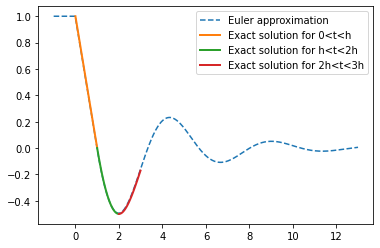

In [12]:
# Plotting
lam_x = utilities.lambdify(t, sys_2h_3h.subs(a, a_val).subs(h, h_val), modules=['numpy'])
sys_2h_3h.subs(a, a_val).subs(h, h_val)

time_2h_3h = np.arange(2*h_val, 3*h_val, 0.01)
X_2h_3h = [lam_x(t) for t in time_2h_3h]
plt.plot(T, X, label='Euler approximation', linestyle='--')
plt.plot(time_0_h, X_0_h, linewidth=2.0, label='Exact solution for 0<t<h')
plt.plot(time_h_2h, X_h_2h, linewidth=2.0, label='Exact solution for h<t<2h')
plt.plot(time_2h_3h, X_2h_3h, linewidth=2.0, label='Exact solution for 2h<t<3h')

plt.legend()